In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Getting lyrics from txt

In [2]:
author = 'mamonas'

lyrics = os.listdir('lyrics/' + author)

data = ''

for i in range(len(lyrics)):
    with open('lyrics/' + author + '/' + lyrics[i], 'r', encoding='utf-8') as f:
        lyrics_data = f.read().replace('\r', ' ')
        lyrics_data = "\n".join(line for line in lyrics_data.split("\n") if line.strip())
        data += lyrics_data

## Building the Word Vocabulary


In [3]:
# Split the long string per line and put in a list
corpus = data.lower().split("\n")

# Preview the result
print(corpus)

['atenção, creuzebek', 'ao top de quatro já vai', 'já, já, já, já vai!', 'eu queria um apartamento no guarujá', 'mas o melhor que eu consegui foi um barraco em itaquá', 'você não sabe como parte um coração', 'ver seu filhinho chorando, querendo ter um avião', 'você não sabe como é frustrante', 'ver sua filhinha chorando por um colar de diamante', 'cê não sabe como eu fico chateado', 'ver meu cachorro babando por um carro importado', 'money', 'que é good nós num have (have)', 'se nós hevasse, nós num tava aqui playando', 'mas nós precisa de workar', 'money (money)', 'que é good nós num have (have)', 'se nós hevasse, nós num tava aqui workando', 'o nosso work é playá', 'mas a pior de todas é minha mulher', 'tudo que ela olha, a desgraçada quer', 'televisão, micro-ondas, micro system, microscópio', 'limpa-vidro, limpa-chifre e facas ginsu', 'eu sou cagado, veja só como é que é', 'se der uma chuva de xuxa, no meu colo cai pelé', 'é como aquele ditado que já dizia', 'pau que nasce torto mij

In [4]:
# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

word index dictionary: {'que': 1, 'é': 2, 'a': 3, 'e': 4, 'de': 5, 'nós': 6, 'não': 7, 'eu': 8, 'um': 9, 'o': 10, 'num': 11, 'roda': 12, 'me': 13, 'com': 14, 'have': 15, 'você': 16, 'se': 17, 'ai': 18, 'no': 19, 'meu': 20, 'já': 21, 'mas': 22, 'money': 23, 'como': 24, 'aqui': 25, 'ela': 26, 'te': 27, 'na': 28, 'good': 29, 'minha': 30, 'uma': 31, 'da': 32, 'hevasse': 33, 'tava': 34, 'do': 35, 'arrebita': 36, 'os': 37, 'pra': 38, 'oxente': 39, 'yeah': 40, 'gay': 41, 'vem': 42, 'mão': 43, 'foi': 44, 'em': 45, 'quer': 46, 'mais': 47, 'amor': 48, 'very': 49, 'doce': 50, 'maria': 51, 'vira': 52, 'solta': 53, 'passaram': 54, 'bunda': 55, 'ainda': 56, 'comi': 57, 'ninguém': 58, 'por': 59, 'pé': 60, 'momento': 61, 'dos': 62, 'estou': 63, 'está': 64, 'sei': 65, 'oh': 66, 'suruba': 67, 'vai': 68, 'ver': 69, 'seu': 70, 'playando': 71, 'precisa': 72, 'workar': 73, 'workando': 74, 'nosso': 75, 'work': 76, 'sou': 77, 'só': 78, 'toda': 79, 'vida': 80, 'neste': 81, 'bom': 82, 'hoje': 83, 'lindia': 84, 

## Preprocessing the Dataset


In [5]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:

	# Tokenize the current line
	token_list = tokenizer.texts_to_sequences([line])[0]

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):

		# Generate the subphrase
		n_gram_sequence = token_list[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [6]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence:
  word = "".join([l for l in word if l.isalnum()])
  token_list.append(tokenizer.word_index[word])

# Print the token list
print(token_list)

sample sentence: ['atenção,', 'creuzebek']
[210, 211]


In [7]:
# Pick element
elem_number = 6

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')


token list: [ 0  0  0  0  0  0  0  0  0 21]
decoded to text: ['já']


## Build the Model


In [29]:
# Build the model
model = Sequential([
          Embedding(total_words, 128, input_length=max_sequence_len-1),
          Bidirectional(LSTM(100)),
          Dense(total_words, activation='softmax')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.05)

# Use categorical crossentropy because this is a multi-class problem
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 128)           68608     
                                                                 
 bidirectional_2 (Bidirecti  (None, 200)               183200    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 536)               107736    
                                                                 
Total params: 359544 (1.37 MB)
Trainable params: 359544 (1.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train the model


In [30]:
# Train the model
history = model.fit(xs, ys, epochs=100)

Epoch 1/100
39/39 [==============================] - 4s 5ms/step - loss: 6.1400 - accuracy: 0.0488
Epoch 2/100
39/39 [==============================] - 0s 5ms/step - loss: 4.6306 - accuracy: 0.2026
Epoch 3/100
39/39 [==============================] - 0s 5ms/step - loss: 3.7249 - accuracy: 0.2945
Epoch 4/100
39/39 [==============================] - 0s 5ms/step - loss: 2.9716 - accuracy: 0.3792
Epoch 5/100
39/39 [==============================] - 0s 5ms/step - loss: 2.4722 - accuracy: 0.4451
Epoch 6/100
39/39 [==============================] - 0s 5ms/step - loss: 2.5191 - accuracy: 0.4638
Epoch 7/100
39/39 [==============================] - 0s 5ms/step - loss: 2.2288 - accuracy: 0.5207
Epoch 8/100
39/39 [==============================] - 0s 5ms/step - loss: 2.1899 - accuracy: 0.5053
Epoch 9/100
39/39 [==============================] - 0s 5ms/step - loss: 2.0452 - accuracy: 0.5313
Epoch 10/100
39/39 [==============================] - 0s 5ms/step - loss: 1.8589 - accuracy: 0.5622
Epoch 11/

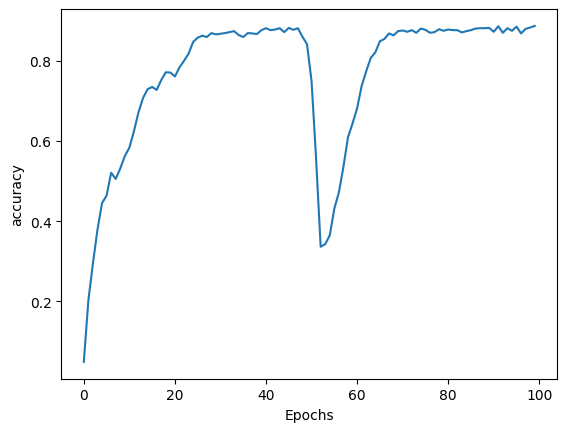

In [31]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

## Generating Text


In [32]:
# Define seed text
seed_text = "A minha mão quer"

# Define total words to predict
next_words = 10

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(token_list)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:

		# Look up the word associated with the index.
		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result
print(seed_text)

1/1 [==============================] - 0s 17ms/step
A minha mão quer católico cabelo pixaim deu jabá o a chupar a barba


In [33]:
# Define seed text
seed_text = "Estou pensando em"

# Define total words to predict
next_words = 12

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])

  # Sort the probabilities in ascending order
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:
    output_word = tokenizer.index_word[predicted]
    seed_text += " " + output_word

# Print the result
print(seed_text)

1/1 [==============================] - 0s 19ms/step
Estou pensando em toda a fazer com vinagre doce que o pediatra olha eu conquistchar
